# Part 4 -- Model v2 Training -- Base LLM model on the "Industry" and "Meta-description" features

In [2]:
import evaluate
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import torch

from datasets import Dataset, DatasetDict
from sklearn.preprocessing import LabelEncoder
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, EarlyStoppingCallback, Trainer, TrainingArguments

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load exported Full dataset to a Pandas DataFrame

In [4]:
df = pd.read_csv(os.path.join('data', 'dataset.csv'))

In [5]:
# Percentage of missing values
df.isna().mean()

id                  0.000000
industry            0.000000
homepage_text       0.986547
meta_description    0.987719
category            0.986424
dtype: float64

In [6]:
# Data features types
df.dtypes

id                   int64
industry            object
homepage_text       object
meta_description    object
category            object
dtype: object

In [7]:
model_name = 'ft2'
text_cols = ['industry', 'meta_description']
label_col = 'category'

In [8]:
df = df.dropna(subset=text_cols+[label_col]).reset_index(drop=True)

## Data transformation based on Label (category) and Text (input) feature(s)

In [9]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    # Removing HTML tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Remove redundant whitespaces at the beginning and at the end
    sentence = sentence.strip()

    return sentence


for col in text_cols:
    texts = []
    for sen in list(df[col].astype(str)):
        texts.append(preprocess_text(sen))

    df.loc[:, col] = pd.Series((sen for sen in texts))

In [10]:
df['text'] = df[text_cols].apply(lambda x: ' [SEP] '.join(x.values.astype(str)), axis=1)
df = df.dropna(subset=['text']).reset_index(drop=True)

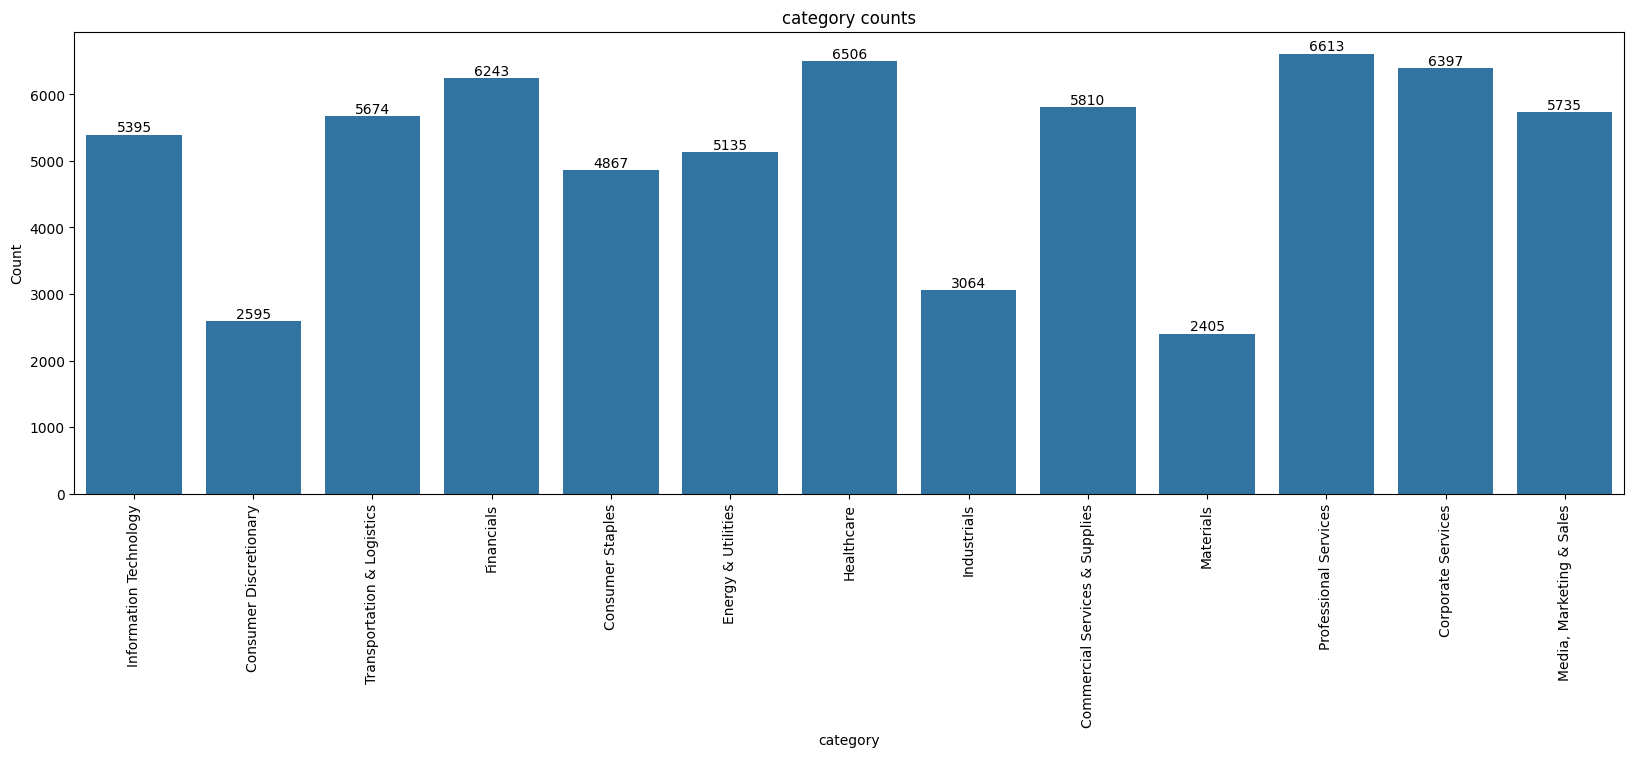

In [11]:
plt.figure(figsize=(20, 6))

ax = sns.countplot(data=df, x=label_col)

plt.title(f'{label_col} counts')

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 5), 
                textcoords = 'offset points')

plt.ylabel('Count')
plt.xlabel(label_col)
plt.xticks(rotation=90)
plt.show()

In [12]:
le = LabelEncoder()
le.fit(df[label_col])

le_keys = le.classes_
le_values = le.transform(le_keys)
le_params = dict(zip(le_keys, le_values))

with open(os.path.join('data', 'labels.json'), 'w') as fp:
    json.dump(le_params, fp, default=str)

In [13]:
df['label'] = le.transform(df[label_col])

In [14]:
num_labels = df['label'].nunique()
label_min_count = df.groupby('label').size().min()

print('Lowest label samples count:', label_min_count)

Lowest label samples count: 2405


In [15]:
print('Percentage of missing values')
df.isna().mean()

Percentage of missing values


id                  0.000000
industry            0.000000
homepage_text       0.004756
meta_description    0.000000
category            0.000000
text                0.000000
label               0.000000
dtype: float64

## Split data into class-balanced Training and Test sets

In [16]:
eval_dataset_frac = 0.15
train_dataset_frac = 1 - eval_dataset_frac

In [17]:
train_dataset_counts_per_label = int(math.floor(label_min_count * (1 - eval_dataset_frac)))
eval_dataset_counts_per_label = label_min_count - train_dataset_counts_per_label

print('Training samples count per label:', train_dataset_counts_per_label)
print('Training samples count per label:', eval_dataset_counts_per_label)

Training samples count per label: 2044
Training samples count per label: 361


In [18]:
dfgb = df.groupby(by=[label_col])
df_train = dfgb.apply(lambda group: group.sample(n=train_dataset_counts_per_label, random_state=13), include_groups=False)
df_train = df_train.reset_index(level=0, drop=False)

df_train.drop(columns=['text', 'label']).to_csv(os.path.join('data', 'train.csv'), index=False)
df_train.count()

category            26572
id                  26572
industry            26572
homepage_text       26451
meta_description    26572
text                26572
label               26572
dtype: int64

In [19]:
dfgb = df[~df['id'].isin(df_train['id'])].groupby(by=[label_col])
df_eval = dfgb.apply(lambda group: group.sample(n=eval_dataset_counts_per_label, random_state=13), include_groups=False)
df_eval = df_eval.reset_index(level=0, drop=False)

df_eval.drop(columns=['text', 'label']).to_csv(os.path.join('data', 'eval.csv'), index=False)
df_eval.count()

category            4693
id                  4693
industry            4693
homepage_text       4674
meta_description    4693
text                4693
label               4693
dtype: int64

## Tokenize text data

In [20]:
# Tokenize text features
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [21]:
ds_train = Dataset.from_pandas(df_train[['label', 'text']])
ds_eval = Dataset.from_pandas(df_eval[['label', 'text']])

ds = DatasetDict({
    'train': ds_train, 
    'eval': ds_eval
})

In [22]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

tokenized_datasets = ds.map(tokenize_function)

Map: 100%|███████████████████████████████████████████████████████| 4693/4693 [00:01<00:00, 2763.63 examples/s]


## Configure model training parameters

In [23]:
configuration = AutoConfig.from_pretrained('bert-base-uncased', num_labels=num_labels)
configuration.hidden_dropout_prob = 0.2
configuration.attention_probs_dropout_prob = 0.2

model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', config=configuration)

# Move model to the proper device
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [24]:
training_args = TrainingArguments(
    push_to_hub=False,
    output_dir='output',
    num_train_epochs=3,
    per_device_train_batch_size=13,
    per_device_eval_batch_size=13*int(6*len(df_eval)/len(df_train)),

    save_strategy='steps',
    eval_strategy='steps',
    save_steps=200,
    eval_steps=200,
    logging_steps=200,
    
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    load_best_model_at_end=True,
)

In [25]:
accuracy_metric = evaluate.load('accuracy')
precision_metric = evaluate.load('precision')
recall_metric = evaluate.load('recall')
f1_metric = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    return {
        'Accuracy': accuracy_metric.compute(predictions=predictions, references=labels)['accuracy'],
        'F1': f1_metric.compute(predictions=predictions, references=labels, average='weighted')['f1'],
        'Precision': precision_metric.compute(predictions=predictions, references=labels, average='weighted')['precision'],
        'Recall': recall_metric.compute(predictions=predictions, references=labels, average='weighted')['recall'],
    }

In [26]:
early_stop = EarlyStoppingCallback(5, 1e-4)

In [27]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['eval'],
    compute_metrics=compute_metrics,
    callbacks=[early_stop],
)

## Train model

In [28]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
200,0.838000,0.022558,0.997443,0.997444,0.997460,0.997443
400,0.017300,0.013125,0.998295,0.998296,0.998304,0.998295
600,0.008100,0.008375,0.998935,0.998934,0.998938,0.998935
800,0.008300,0.003782,0.999361,0.999361,0.999364,0.999361
1000,0.010700,0.001797,0.999361,0.999361,0.999363,0.999361
1200,0.002200,0.000523,1.000000,1.000000,1.000000,1.000000
1400,0.005300,0.001193,0.999787,0.999787,0.999788,0.999787
1600,0.000500,0.001328,0.999787,0.999787,0.999788,0.999787
1800,0.000500,0.000635,0.999787,0.999787,0.999788,0.999787
2000,0.000900,0.000246,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=3000, training_loss=0.0605621397147576, metrics={'train_runtime': 4511.4299, 'train_samples_per_second': 17.67, 'train_steps_per_second': 1.359, 'total_flos': 1.0262344614912e+16, 'train_loss': 0.0605621397147576, 'epoch': 1.467710371819961})

In [29]:
trainer.evaluate()

{'eval_loss': 0.00024646002566441894,
 'eval_Accuracy': 1.0,
 'eval_F1': 1.0,
 'eval_Precision': 1.0,
 'eval_Recall': 1.0,
 'eval_runtime': 119.1065,
 'eval_samples_per_second': 39.402,
 'eval_steps_per_second': 3.031,
 'epoch': 1.467710371819961}

## Store trained model

In [30]:
trainer.save_model(os.path.join('output', model_name))